In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np

# ngSolve Example for the Calculation of Eddy Current Losses in Permanet Magnets

## Introduction

In this example the eddy current losses in a permanent magnet motor are calculated. 


1. full problem
1. quasi-periodic boundaries


## Geometry

In the first step the full geometry of the problem with two magnets attached to a cylindrical rotor is simulated. 

In [2]:
## mesh
from permanentMagnetGeometry import  fullGeoMagnet
from ngsolve.webgui import Draw


r1, r2, r3, r4, phi_deg, maxh = 0.01, 0.02, 0.03, 0.032, 45, 0.001
maxh = 0.1
maxhEdges = 0.001

order0 = 2

cMesh = fullGeoMagnet(r1, r2, r3, r4, phi_deg=45, maxh=maxh, maxhEdges=maxhEdges, periodic=False)
mesh = cMesh.mesh


print("domains", mesh.GetMaterials())
print("boundaries", set(mesh.GetBoundaries()))

Draw(CF([0, 1, 2, 3]), mesh)


domains ('air', 'rotor', 'magnet_top', 'magnet_bottom')
boundaries {'inner', 'outer', 'mag_rot', 'interface'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Biot-Savart Field $H_{BS}$ of a Single Conductor
The Biot-Savart field of a filament current is derived from Ampere's law and yields 
\begin{align}
    \mathbf{H}_{BS} = \frac{I_0}{2\pi||\mathbf{r}||}\mathbf{e}_{\varphi}
\end{align}
for the magentic field strength $H_{BS}$ in the distance $\mathbf{r}$ form a filament current. 


### Excitation of the Problem

Further, the excitation of the problem is given by a three-phase current network
\begin{align*}
i_u &= i_0 e^{j(\omega t)}\\
i_v &= i_0 e^{j(\omega t + 120^\circ)}\\
i_w &= i_0 e^{j(\omega t - 120^\circ)}\\
\end{align*}
surrounding the motor. 

In [3]:

# ------------------------------------------------------------------------------
# --- excitation
# ------------------------------------------------------------------------------
f = 50
omega = 2*np.pi * f


def HBS_singleConductor(I0, xy_center, dim=2):

    # shifted coordninates
    x_s = x - xy_center[0]
    y_s = y - xy_center[1]

    r = sqrt(x_s ** 2 + y_s **2)

    if dim == 2:
        e_phi = CF((y_s, -x_s))/(r+1e-15)
    else:
        e_phi = e_phi = CF((y_s, -x_s, 0))/(r+1e-15)

    return I0/(2*np.pi*r + 1e-15) * e_phi


# angles
N_BS = 3
phi_i = [i * 2*np.pi/N_BS for i in range(N_BS)]

# centeres of the filament currents
points_pos = [(r4 * cos(phi), r4*sin(phi)) for phi in phi_i]
H_BS_i = [HBS_singleConductor(1 * np.exp(1j * phi), xy) for xy, phi in zip(points_pos, phi_i)]



points_neg = [(r4 * cos(phi + np.pi), r4*sin(phi+ np.pi)) for phi in phi_i]
H_BS_i += [HBS_singleConductor(-1 * np.exp(1j * phi), xy) for xy, phi in zip(points_neg, phi_i)]

HBS = sum(H_BS_i)


# draw them on the mesh
colors = ["blue", "red", "yellow"]
points = [{ "type": "points", "position": [points_pos[i][0], points_pos[i][1], 0, points_neg[i][0], points_neg[i][1], 0,], "size":20, "color": colors[i%N_BS], "name": "points_u"} for i in range(N_BS)]    
# points_u = { "type": "points", "position": [points_pos[0][0], points_pos[0][1], 0, points_neg[0][0], points_neg[0][1], 0,], "size":20, "color": "blue", "name": "points_u"}
# points_v = { "type": "points", "position": [points_pos[1][0], points_pos[1][1], 0, points_neg[1][0], points_neg[1][1], 0,], "size":20, "color": "red", "name": "points_v"}
# points_w = { "type": "points", "position": [points_pos[2][0], points_pos[2][1], 0, points_neg[2][0], points_neg[2][1], 0,], "size":20, "color": "yellow", "name": "points_w"}
Draw(mesh, objects=points)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [4]:

# ------------------------------------------------------------------------------
# --- materials
# ------------------------------------------------------------------------------
sigma_Fe = 2e6
sigma_air = 0
sigma_magnet = 556e3

mu_air = 4e-7*np.pi
mu_Fe = 1000 * mu_air
mu_magnet = 1.05 * mu_air



## $\mathbf{A}$ Formulation

Based on Maxwell's equation of the eddy current problem in the time harmonic case
\begin{align*}
\nabla\times\mathbf{H} &= \mathbf{J}\\
\nabla\times\mathbf{E} &= -j\omega \mathbf{B}\\
\nabla\cdot\mathbf{B} &= 0
\end{align*}
and the related constitutive relations $\mathbf{H} = \nu \mathbf{B}, \mathbf{J} = \sigma\mathbf{E}$ the weak form of the boundary value problem with the magnetic vector Potential $\mathbf{A}$

\begin{align*}
\int_\Omega \nu\nabla\times\mathbf{A}\cdot\nabla\times\mathbf{A}' + j\omega\sigma\mathbf{A}\cdot\mathbf{A}' \;d\Omega = \int_\Omega\mathbf{H}_{BS}\cdot\nabla\times\mathbf{A}'\;d\Omega
\end{align*}

with homogeneous Dirichlet boundaries on the inner and the outer boundary can be derived. 


In two dimensions the magnetic vector potential can be represented by a single component magnetic vector potential $u(x, y)$
\begin{align*}
\mathbf{A} = u \mathbf{e}_z \text{ and } \mathbf{B} = \nabla\times\mathbf{A} = \partial_y u\mathbf{e}_x - \partial_x u\mathbf{e}_x
\end{align*}
which yields the boundary value problem in two dimensions

\begin{align*}
\int_{\Omega_{2D}} \nu\nabla u\cdot \nabla u' + j\omega\sigma u\cdot u' \;d\Omega = \int_{\Omega_{2D}}\mathbf{H}_{BS}\cdot (\partial_y u'\mathbf{e}_x - \partial_x u'\mathbf{e}_x)\;d\Omega.
\end{align*}


In [5]:


def solveFullWithA(mesh, order0, omega, HBS, periodic=False):

    # ------------------------------------------------------------------------------
    # --- materials
    # ------------------------------------------------------------------------------
    mu = mesh.MaterialCF({"air": mu_air, "rotor": mu_Fe, "magnet.*": mu_magnet}, default=0.001)
    nu = 1/mu
    sigma = mesh.MaterialCF({"air": sigma_air, "rotor": sigma_Fe, "magnet.*": sigma_magnet}, default=0.001)
    rho = 1/sigma
    
    # ------------------------------------------------------------------------------
    # --- fem
    # ------------------------------------------------------------------------------
    dir_A = "inner"

    if periodic:
        fes = Periodic(H1(mesh, order=order0, dirichlet=dir_A, complex=True), phase=[-1, -1])
    else:
        fes = H1(mesh, order=order0, dirichlet=dir_A, complex=True)
    

    u, v = fes.TnT()


    sol = GridFunction(fes, "A")
    gradsol = grad(sol)


    # ------------------------------------------------------------------------------
    # --- fields
    # ------------------------------------------------------------------------------
    B = CF((gradsol[1], -gradsol[0]))
    H = nu * B
    E = -1j * omega * sol
    J = sigma * E


    # ------------------------------------------------------------------------------
    # --- formulation
    # ------------------------------------------------------------------------------

    ah = BilinearForm(fes, symmetric=True)
    ah += nu * grad(u) * grad(v) * dx
    ah += 1j * omega * sigma * u * v * dx("rotor|magnet.*")


    prec = Preconditioner(ah, type="direct")

    gradv = grad(v)
    f = LinearForm(fes)
    f  += HBS * CF((gradv[1], -gradv[0])) * dx


    ah.Assemble()
    f.Assemble()

    # solve it
    solvers.BVP(bf = ah, lf= f, pre=prec, gf=sol, maxsteps=10)


    losses_magnet = .5 * Integrate(InnerProduct(E, J), mesh, definedon=mesh.Materials("magnet.*")).real
    losses_rotor = .5 * Integrate(InnerProduct(E, J), mesh, definedon=mesh.Materials("rotor")).real

    if periodic:
        losses_magnet *= 2
        losses_rotor *= 2

    return sol, B, E, H, J, losses_magnet, losses_rotor

A, B_A, E_A, H_A, J_A, losses_magnet_A, losses_rotor_A = solveFullWithA(mesh, order0, omega=omega, HBS=HBS)

CG iteration 1, residual = 0.0002300283900072151     
CG iteration 2, residual = 1.3481703219722107e-16     


In [6]:
draw_settings = {"Objects":{"Wireframe":False}}
sceneJ_A  = Draw(J_A, mesh, max = 500, min = -500, animate_complex=True, settings=draw_settings, objects=points)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…


## $\mathbf{T}$,$\Phi$ - $\Phi$ Formulation

With the current vetor potential $\mathbf{T}$ and the magnetic scalar potential $\Phi$ the weak formulation of the boundary value problem 

\begin{align}
\int_{\Omega} \rho\nabla\times\mathbf{T}\cdot\nabla\times\mathbf{T}' + j\omega\mu(\mathbf{T}-\nabla\Phi)\cdot(\mathbf{T}'-\nabla\Phi') \;d\Omega = -\int_\Omega j\omega\mu(\mathbf{H}_{BS})\cdot(\mathbf{T}'-\nabla\Phi')\;d\Omega
\end{align}

with homogeneous Dirichlet boundaries on the interface and the inner for $\mathbf{T}$ and on the outer for $\Phi$ can be derived.


In the curl of the current vector potential is defiend as 
\begin{align}
\mathbf{J} = \nabla\times\mathbf{T} =\nabla\times(T_x\mathbf{e}_x + T_y\mathbf{e}_y) = (\partial_x T_x + \partial_y T_y)\mathbf{e}_z.
\end{align}

<!---
and therefore 
\begin{align}
\int_{\Omega_{2D}} \rho\nabla \times \mathbf{T} \cdot \nabla \times \mathbf{T}' + j\omega\mu (\mathbf{T} - \nabla\Phi)\cdot (\mathbf{T}' - \nabla\Phi') \;d\Omega = -\int_\Omega j\omega\mu(\mathbf{H}_{BS})\cdot(\mathbf{T}'-\nabla\Phi')\;d\Omega
\end{align}
--->


In [7]:
def solveFullWithTPhi(mesh, order0, omega, HBS, periodic = False):

    # ------------------------------------------------------------------------------
    # --- materials
    # ------------------------------------------------------------------------------
    mu = mesh.MaterialCF({"air": mu_air, "rotor": mu_Fe, "magnet.*": mu_magnet}, default=0.001)
    nu = 1/mu
    sigma = mesh.MaterialCF({"air": sigma_air, "rotor": sigma_Fe, "magnet.*": sigma_magnet}, default=0.001)
    rho = 1/sigma
    
    # ------------------------------------------------------------------------------
    # --- fem
    # ------------------------------------------------------------------------------

    dir_T  = "interface|inner"
    dir_Phi  = "outer"


    fesT = HCurl(mesh, order=order0, dirichlet=dir_T, complex=True, definedon=mesh.Materials("rotor|magnet.*"))
    fesPhi = H1(mesh, order=order0+1, dirichlet=dir_Phi, complex=True)

    if periodic:
        phase = [-1, -1]
        fes = FESpace([Periodic(fesPhi,phase), Periodic(fesT, phase)])
    else:
        fes = FESpace([fesPhi, fesT])

    trials = fes.TrialFunction()
    tests = fes.TestFunction()


    uPhi, vPhi = trials[0], tests[0]
    uT, vT = trials[1], tests[1]

    sol = GridFunction(fes, "sol")
    Phi = sol.components[0]
    T = sol.components[1]



    # ------------------------------------------------------------------------------
    # --- fields
    # ------------------------------------------------------------------------------
    H = HBS + T - grad(Phi)
    B = mu * H 
    J = curl(T)
    E = rho * J 


    # ------------------------------------------------------------------------------
    # --- formulation
    # ------------------------------------------------------------------------------

    ah = BilinearForm(fes, symmetric=True)
    ah += rho * curl(uT) * curl(vT) * dx("rotor|magnet.*")
    ah += 1j * omega * mu * (uT - grad(uPhi)) * (vT - grad(vPhi)) * dx("rotor|magnet.*")
    ah += 1j * omega * mu * (- grad(uPhi)) * (- grad(vPhi)) * dx("air")

    ah += 1e-3 * uPhi * vPhi * dx("rotor|magnet.*")

    prec = Preconditioner(ah, type="direct")



    f = LinearForm(fes)
    f  += - 1j*omega * mu *  HBS * (vT - grad(vPhi)) * dx



    ah.Assemble()
    f.Assemble()


    solvers.BVP(bf = ah, lf= f, pre=prec, gf=sol, maxsteps=10)
    # sol.vec.data = ah.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec


    losses_magnet = .5 * Integrate(InnerProduct(E, J), mesh, definedon=mesh.Materials("magnet.*")).real
    losses_rotor = .5 * Integrate(InnerProduct(E, J), mesh, definedon=mesh.Materials("rotor")).real

    if periodic:
        losses_magnet *= 2
        losses_rotor *= 2

    return T, Phi, B, E, H, J, losses_magnet, losses_rotor

T, Phi, B_TPhi, E_TPhi, H_TPhi, J_TPhi, losses_magnet_TPhi, losses_rotor_TPhi = solveFullWithTPhi(mesh, order0, omega, HBS=HBS)

CG iteration 1, residual = 0.006715525597458756     
CG iteration 2, residual = 3.082831786179662e-10     
CG iteration 3, residual = 1.8489689489690308e-13     


In [8]:
#animate(J, mesh, ti= np.linspace(0, 4*np.pi, 150), pause=0.01 )
sceneJ_TPhi  = Draw(J_TPhi, mesh, animate=True, max = 500, min = -500, animate_complex=True, settings=draw_settings, objects=points)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

## Quasi Periodic Boundaries

boundaries in mesh have to be _identified_ as well

The phase shift from the left boundary to the right boundary is $e^{-j\pi} = -1$

In [9]:
cMesh_periodic = fullGeoMagnet(r1, r2, r3, r4, phi_deg=45, maxh=maxh, maxhEdges=maxhEdges, periodic=True)
mesh_periodic = cMesh_periodic.mesh

print("domains", mesh_periodic.GetMaterials())
print("boundaries", set(mesh_periodic.GetBoundaries()))

Draw(mesh_periodic, objects=points)

domains ('air', 'rotor', 'magnet_top')
boundaries {'periodic_rotor', 'interface', 'periodic_air', 'mag_rot', 'outer', 'inner'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### $\mathbf{A}$ Formulation

In [10]:

A, B_A_per, E_A_per, H_A_per, J_A_per, \
    losses_magnet_A_per, losses_rotor_A_per \
    = solveFullWithA(mesh_periodic, order0, omega=omega, HBS=HBS, periodic=True)

CG iteration 1, residual = 0.0004851190994347406     
CG iteration 2, residual = 6.26103975717427e-17     


In [11]:
sceneJ_APer = Draw(J_A_per, mesh_periodic, max = 500, min = -500, animate_complex=True,settings=draw_settings, objects=points) 

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

## $\mathbf{T}$,$\Phi$ - $\Phi$ Formulation

In [12]:
T_per, Phi_per, B_TPhi_per, E_TPhi_per, \
    H_TPhi_per, J_TPhi_per, \
    losses_magnet_TPhi_per, losses_rotor_TPhi_per \
    = solveFullWithTPhi(mesh_periodic, order0, omega, HBS=HBS, periodic=True)

CG iteration 1, residual = 0.0052822857252045625     
CG iteration 2, residual = 2.0750043036019185e-10     
CG iteration 3, residual = 6.079445473254431e-14     


In [13]:
sceneJ_TPhi  = Draw(J_TPhi_per, mesh_periodic, animate=True, max = 500, min = -500, animate_complex=True, settings=draw_settings, objects=points)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

## Losses

In [14]:
print(f"Losses in the MAGNET")
print(" \t\tA Formulation\t\t T Phi")

print(f"full \t\t{losses_magnet_A*1e6:0.3f} \t\t\t {losses_magnet_TPhi*1e6:0.3f}")
print(f"periodic \t{losses_magnet_A_per*1e6:0.3f} \t\t\t {losses_magnet_TPhi_per*1e6:0.3f}")

print("\n\n")
print(f"Losses in the Rotor")
print(" \t\tA Formulation\t\t T Phi")

print(f"full \t\t{losses_rotor_A*1e6:0.3f} \t\t\t {losses_rotor_TPhi*1e6:0.3f}")
print(f"periodic \t{losses_rotor_A_per*1e6:0.3f} \t\t\t {losses_rotor_TPhi_per*1e6:0.3f}")



Losses in the MAGNET
 		A Formulation		 T Phi
full 		34.704 			 34.662
periodic 	34.614 			 34.638



Losses in the Rotor
 		A Formulation		 T Phi
full 		14.590 			 14.603
periodic 	14.595 			 14.603


## Frequency sweep

In [22]:
omega_i = np.logspace(1, 8, 20) * 2 * np.pi


cMesh_finer = fullGeoMagnet(r1, r2, r3, r4, phi_deg=45, maxh=maxh, maxhEdges=maxhEdges/3, periodic=True)
mesh_finer = cMesh_finer.mesh

In [23]:
T_per, Phi_per, B_TPhi_per, E_TPhi_per, \
    H_TPhi_per, J_TPhi_per, \
    losses_magnet_TPhi_per, losses_rotor_TPhi_per \
    = solveFullWithTPhi(mesh_finer, order0, omega, HBS=HBS, periodic=True)


results_TPhi_per_freq_sweep = [solveFullWithTPhi(mesh_periodic, order0, omega, HBS=HBS, periodic=True) for omega in omega_i]

CG iteration 1, residual = 0.005535118393507313     
CG iteration 2, residual = 1.461677272785263e-06     
CG iteration 3, residual = 6.103390165634258e-07     
CG iteration 4, residual = 4.936031610655069e-07     
CG iteration 5, residual = 2.9386933591969873e-07     
CG iteration 6, residual = 1.99883507439568e-07     
CG iteration 7, residual = 2.0664898896874316e-07     
CG iteration 8, residual = 2.6952415594971386e-07     
CG iteration 9, residual = 3.1745162052915845e-07     
CG iteration 10, residual = 3.237910316431779e-07     
CG iteration 1, residual = 0.0016530182365077377     
CG iteration 2, residual = 1.8854511547860478e-10     
CG iteration 3, residual = 3.1931384081212517e-14     
CG iteration 1, residual = 0.0028881806316389067     
CG iteration 2, residual = 2.915392491156275e-10     
CG iteration 3, residual = 5.934603413600179e-14     
CG iteration 1, residual = 0.005691124330710273     
CG iteration 2, residual = 3.088735231343669e-10     
CG iteration 3, residual

1.4410865326009162e-06


Text(0.5, 0, 'losses in $\\mu$W')

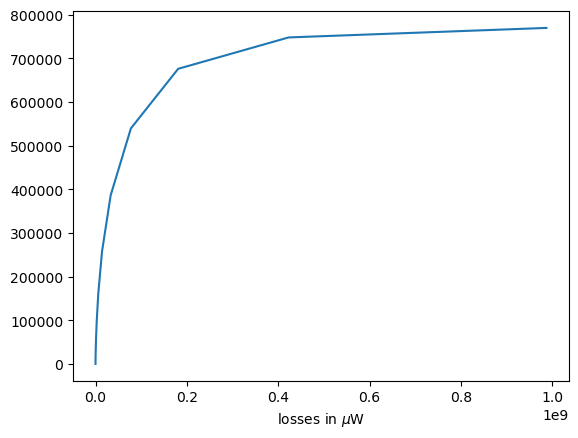

In [25]:
import matplotlib.pyplot as plt


print(results_TPhi_per_freq_sweep[0][6])

losses_magnet_TPhi_per_freq_sweep = [results_TPhi_per_freq_sweep[i][6]* 1e6 for i in range(len(omega_i))]
plt.plot(omega_i/2*np.pi, losses_magnet_TPhi_per_freq_sweep )
plt.xlabel("freqency")
plt.xlabel(r"losses in $\mu$W")